<a href="https://colab.research.google.com/github/KenzaB27/BGNHackathon2021/blob/machine_learning/machine_learning/alphanum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alphabet Machine Learning Model + Metadata Application
This notebook aims to create a working NN model that can correctly determine Alphabets from the ASL sets.

The extensive dataset is provided below:

Dataset Link: https://www.kaggle.com/kuzivakwashe/significant-asl-sign-language-alphabet-dataset

First setp is set our environment up and to download our data from kaggle

# Step 1: Environement setup

In [1]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! pip install -q kaggle

In [4]:
## Upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quintessence18","key":"6f841359e2a88391f87f96d17c915010"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kuzivakwashe/significant-asl-sign-language-alphabet-dataset
!unzip /content/significant-asl-sign-language-alphabet-dataset.zip -d significant-asl-sign-language-alphabet-dataset

In [7]:
from tensorflow import keras
from tqdm import tqdm
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential, load_model, Model

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
tf.random.set_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

import os

# Step 2: Preprocessing

In [9]:
# Set global variables
TRAIN_DIR = '/content/significant-asl-sign-language-alphabet-dataset/significant-asl-alphabet-training-set/Training Set'
TEST_DIR = '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
# CUSTOM_TEST_DIR = '/content/asl-alphabet-test/asl-alphabet-test/'

IMG_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_DIMS = (IMG_SIZE, IMG_SIZE, 3) # add channel for RGB
N_CLASSES = 27
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

# Model saving for easier local iterations
MODEL_DIR = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = True


In [10]:
CATEGORIES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CATEGORIES.sort()

print('Following classes were found:')
print(', '.join(CATEGORIES))

Following classes were found:
A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, space


(149, 91, 3)
(165, 74, 3)
(240, 320, 3)
(159, 82, 3)
(127, 72, 3)
(148, 90, 3)
(112, 164, 3)
(144, 185, 3)
(240, 320, 3)
(240, 360, 3)
(161, 115, 3)
(152, 155, 3)
(155, 79, 3)
(160, 98, 3)
(102, 73, 3)
(144, 83, 3)
(115, 85, 3)
(153, 66, 3)
(124, 75, 3)
(117, 86, 3)
(240, 320, 3)
(152, 85, 3)
(164, 79, 3)
(131, 79, 3)
(128, 128, 3)
(200, 200, 3)
(200, 200, 3)


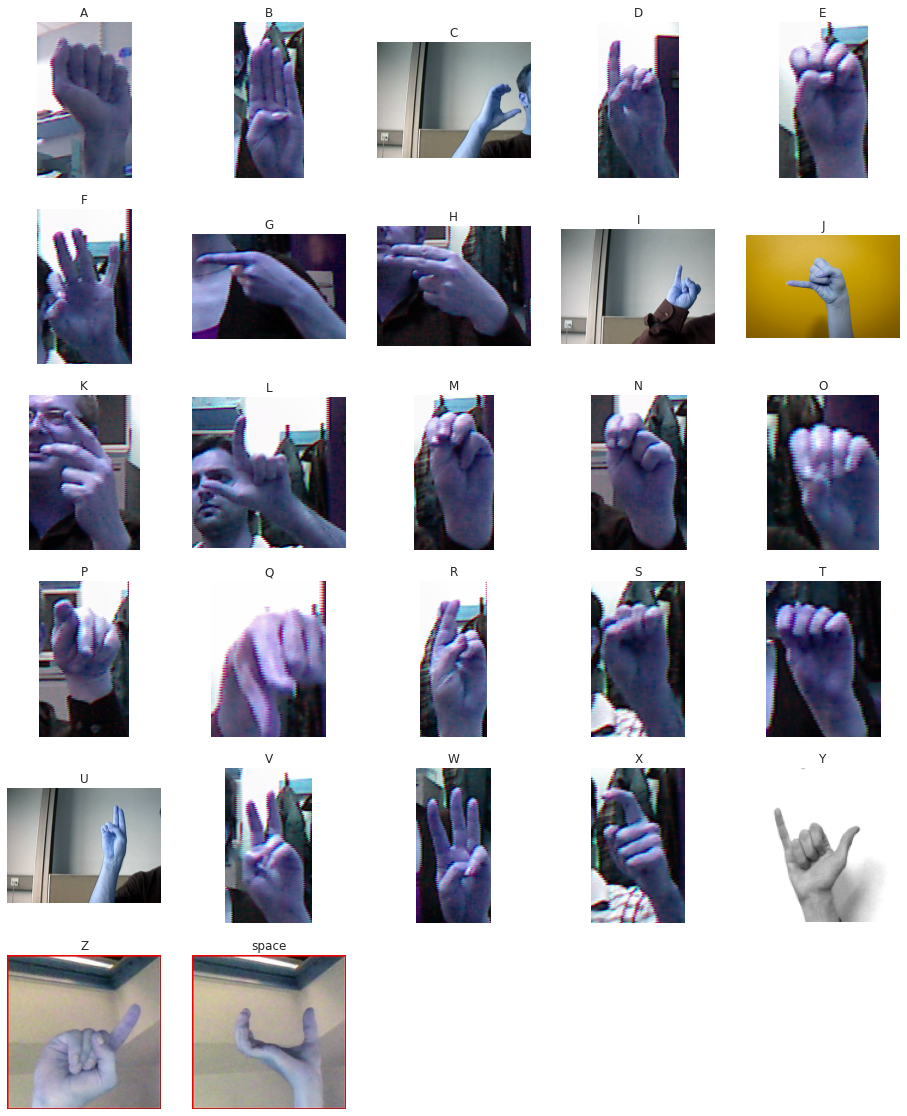

In [11]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CATEGORIES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CATEGORIES)):
        cls = CATEGORIES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        im = cv2.imread(imgs[0])
        print(im.shape)
        plt.imshow(im)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each(TRAIN_DIR)

## Test and Training Data



In [12]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(TRAIN_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████| 3000/3000 [00:02<00:00, 1419.46it/s]


### Shuffle the files

In [13]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])

10
18
12
1
18
19
22
14
24
23


In [14]:
test_data = training_data[76490:]
len(test_data)

1000

In [15]:
training_data = training_data[:76490]
len(training_data)

76490

## Split labels and features

X = features

Y = label

In [16]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

np.save("/content/Kaggle/Working/X.npy", X)
np.save("/content/Kaggle/Working/Y.npy", Y)


(76490, 64, 64, 3)
(76490,)


# Step 3: Build Model

In [17]:
# with tpu_strategy.scope():

model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',input_shape=TARGET_DIMS,activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(N_CLASSES,activation="softmax"))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

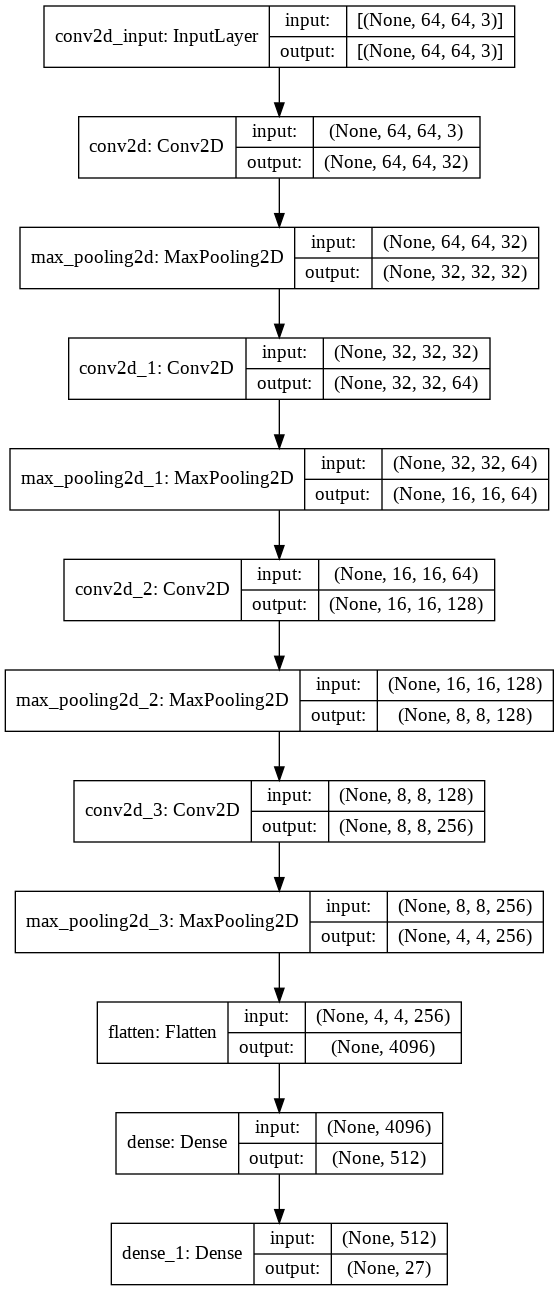

In [19]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign4.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)
with tf.device('/device:GPU:0'):
  history = model.fit(X, Y, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
1913/1913 [==============================] - 46s 7ms/step - loss: 2.2688 - accuracy: 0.6390 - val_loss: 0.2605 - val_accuracy: 0.9237

Epoch 00001: val_accuracy improved from -inf to 0.92365, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign4.h5
Epoch 2/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.2505 - accuracy: 0.9253 - val_loss: 0.2060 - val_accuracy: 0.9363

Epoch 00002: val_accuracy improved from 0.92365 to 0.93633, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign4.h5
Epoch 3/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1718 - accuracy: 0.9473 - val_loss: 0.1500 - val_accuracy: 0.9556

Epoch 00003: val_accuracy improved from 0.93633 to 0.95562, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign4.h5
Epoch 4/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1275 - accuracy: 0.9623 - val_loss: 0.1357 - val_accuracy

In [21]:
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign4.h5'
model.load_weights(checkpoint_filepath)
model.save_weights(checkpoint_filepath)

In [23]:
model.save("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model4")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model4/assets


In [25]:
#Test we can load it back up
reconstructed_model = keras.models.load_model("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model4")

## Evaluate model

In [26]:
len(test_data)

1000

In [27]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

np.save(MODEL_DIR+"X_test.npy", X_test)
np.save(MODEL_DIR+"Y_test.npy", Y_test)


(1000, 64, 64, 3)
(1000,)


In [28]:
loss,acc = model.evaluate(X_test,Y_test)
print(f"Accuracy: {acc*100}")
print(f"Loss: {loss}")

32/32 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9840
Accuracy: 98.4000027179718
Loss: 0.11530567705631256


In [29]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.984

In [30]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        39
           1       1.00      1.00      1.00        43
           2       0.94      0.98      0.96        48
           3       0.98      0.98      0.98        43
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        33
           6       0.97      0.97      0.97        38
           7       1.00      0.95      0.98        43
           8       0.97      0.97      0.97        38
           9       1.00      1.00      1.00         1
          10       0.98      1.00      0.99        40
          11       1.00      1.00      1.00        38
          12       1.00      0.97      0.98        33
          13       0.95      1.00      0.97        35
          14       1.00      1.00      1.00        41
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        38
          17       0.98    

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip /content/asl-alphabet.zip -d asl-alphabet

In [ ]:
import cv2
def test_model(path, model):

  im = cv2.imread(path)

  im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))
  im = im.reshape(1,IMG_SIZE,IMG_SIZE,3)

  plt.imshow(im[0])
  plt.show()
  res = model.predict(im)
  return np.argmax(res)

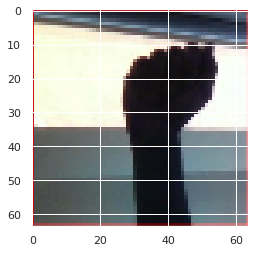

0


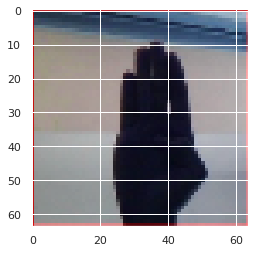

1


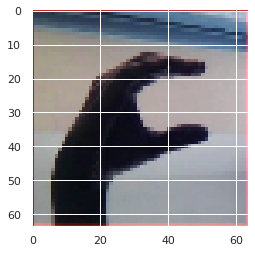

2


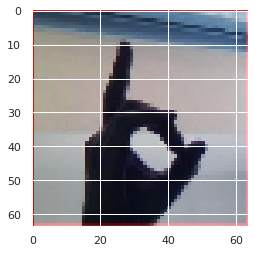

3


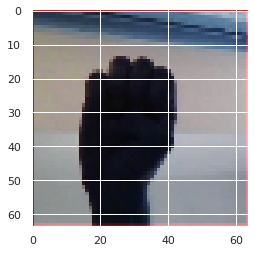

4


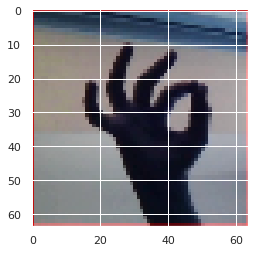

5


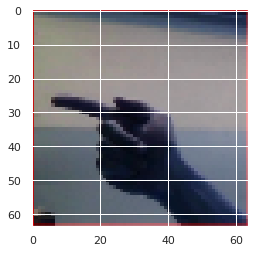

6


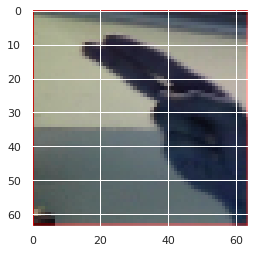

7


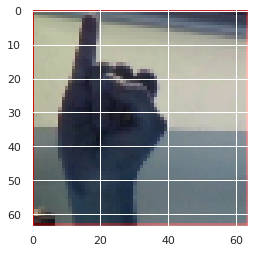

8


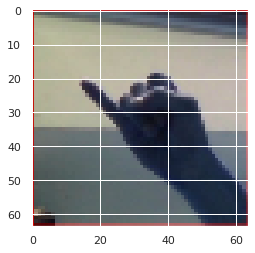

6


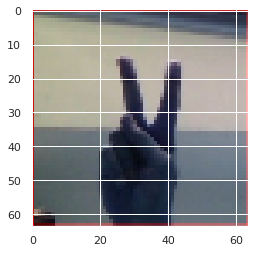

21


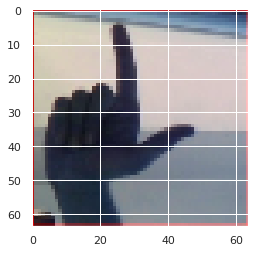

11


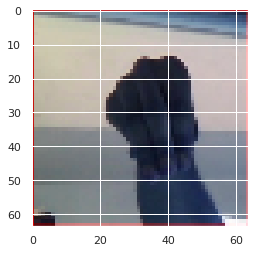

13


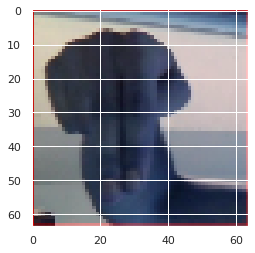

13


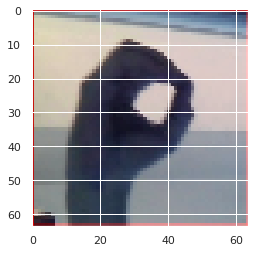

24


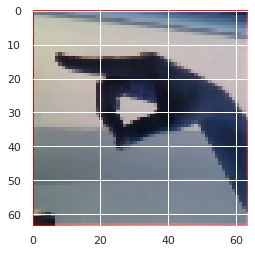

15


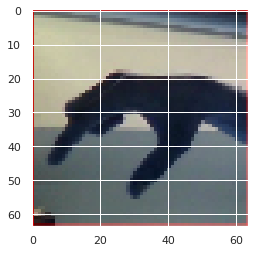

15


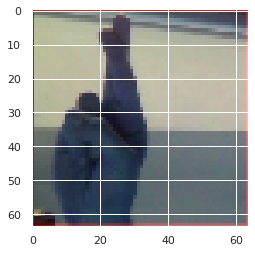

17


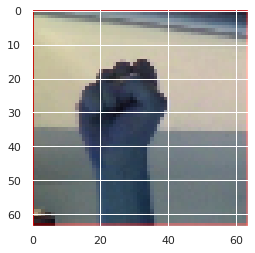

13


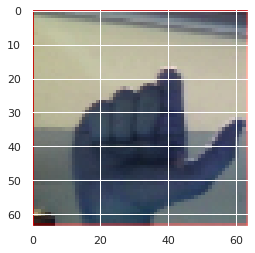

13


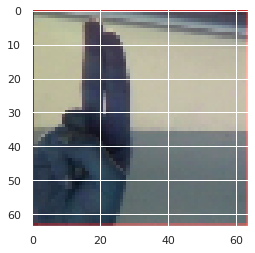

22


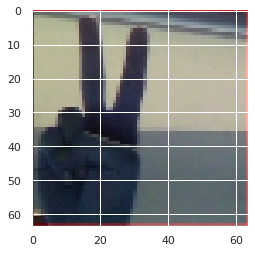

22


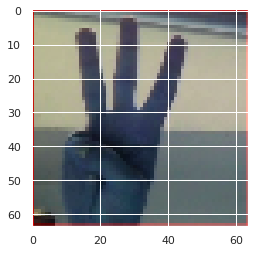

8


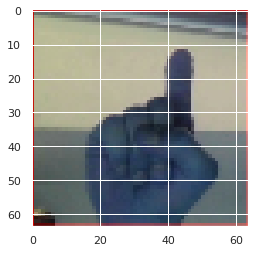

11


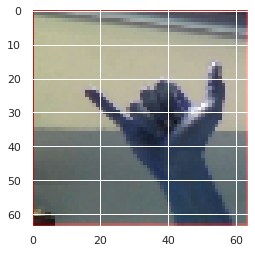

24


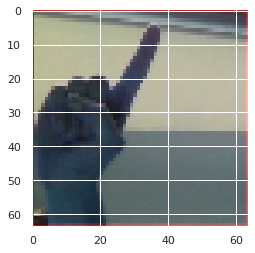

25


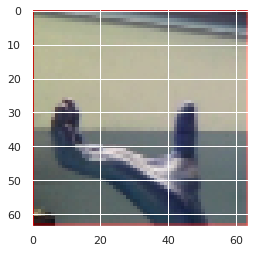

6
15


In [ ]:
count = 0
for i, cat in enumerate(CATEGORIES):
  path = TEST_DIR + cat + "_test.jpg"
  prediction = test_model(path, model)
  if i == prediction: 
    count += 1 
  print(prediction)

print(count)

# Step 4: Convert Model
Convert our saved model to a tflite file


### Method 1  - Method hasn't been used in current uploaded model

In [32]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model4") # path to the SavedModel directory
converter.target_spec.supported_ops = [
tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('/content/gdrive/MyDrive/BGNHackathon/alphabet_model/base_model4.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
# Load TFLite model and allocate tensors.

interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/BGNHackathon/alphabet_model/base_model4.tflite")
interpreter.allocate_tensors()

In [34]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [35]:
# Test model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.07331157 0.03831165 0.01611611 0.02627581 0.03202334 0.03421437
  0.0694151  0.03748447 0.06645948 0.09229749 0.05922913 0.02693253
  0.02451081 0.01593609 0.01449518 0.02814173 0.04811053 0.05254502
  0.05488214 0.01924203 0.01717498 0.01337568 0.03103237 0.00619798
  0.04457976 0.01940718 0.03829741]]


### Method 2 - Used for the current uploaded model

In [38]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model4')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/method2_model4.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3azk744k/assets


INFO:tensorflow:Assets written to: /tmp/tmp3azk744k/assets


10004128

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

# Step 5: Add Metadata to tflite file

Link to source: https://nbviewer.jupyter.org/github/quickgrid/CodeLab/blob/master/tensorflow/TFlite_Object_Detection_Custom_Model_Export_With_Metadata_TF1.ipynb

In [41]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 
import os

In [44]:
!pip install tflite-support

### Create Model Info

In [55]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "ASL Identifier"
model_meta.description = ("Localize the most prominent object in the "
                          "image from a set of N categories such as "
                          "trees, animals, food, vehicles, person etc.")
model_meta.version = "v1"
model_meta.author = "OreoShake"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [56]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

### Set Input Info

In [57]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(64, 64))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

### Set label and exporting Filepaths


In [58]:
labelmap_file = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/labels.txt"

export_model_path = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/method2_model4.tflite"

### Set output Info

In [60]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 27 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(labelmap_file)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

### Create Subgraph Info

In [61]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

### Populate Tfile with set Info

In [62]:
populator = _metadata.MetadataPopulator.with_model_file(export_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([labelmap_file])
populator.populate()